Ours, NLP Performance: [29.784573819121626, 38.81338039207694, 44.42593007323641, 47.61588857507623, 51.504199566223846]
LLaVA, NLP Performance: [24.778255937382223, 37.99028661695316, 43.84293682972429, 45.507539839043936, 48.071109831012684]
Ours, NLP Forgetting: [-2.827230987597183, -0.4044769716439518, 0.7457113821741572, -0.0710792143479253, 0.1977983435102999]
LLaVA, NLP Forgetting: [7.833548869336585, 1.227570746767725, -0.16271813866203644, 2.179427950380216, 3.235291391700862]


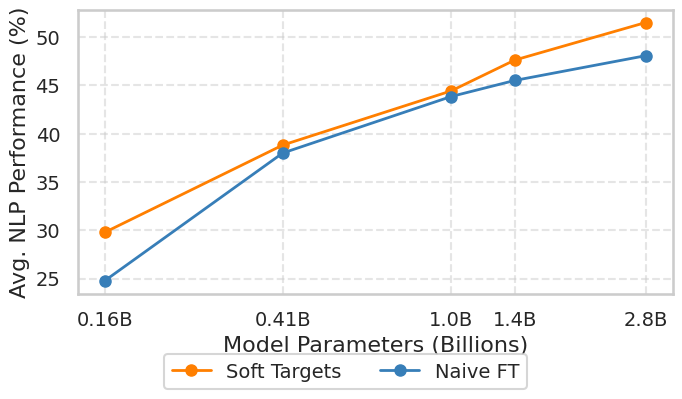

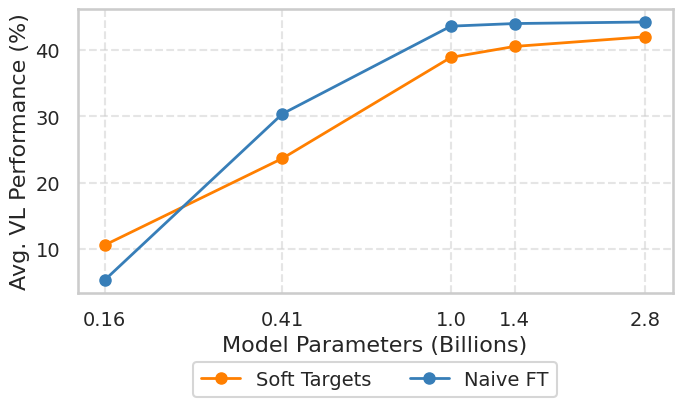

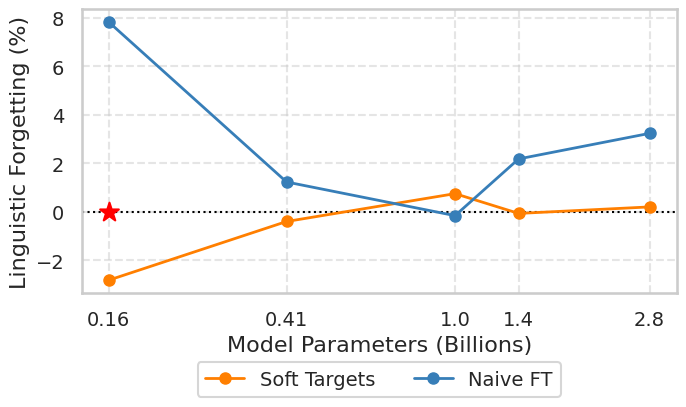

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [7, 4],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A',
              '#F781BF', '#A65628', '#984EA3',
              '#999999', '#E41A1C', '#DEDE00']

# Load the JSON data from the file
with open('results_A.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa"]
all_nlp_datasets = nlu_datasets + nlg_datasets

# Define model scale to model name mapping
model_scale_to_name = {
    0.16: "160m",
    0.41: "410m",
    1.0: "1b",
    1.4: "1p4b",
    2.8: "2p8b"
}

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m",
    0.41: "stage-final-llava-v15-pythia+410m",
    1.0: "stage-final-llava-v15-pythia+1b",
    1.4: "stage-final-llava-v15-pythia+1p4b",
    2.8: "stage-final-llava-v15-pythia+2p8b"
}

our_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m-soft",
    0.41: "stage-final-llava-v15-pythia+410m-soft",
    1.0: "stage-final-llava-v15-pythia+1b-soft",
    1.4: "stage-final-llava-v15-pythia+1p4b-soft",
    2.8: "stage-final-llava-v15-pythia+2p8b-soft"
}

base_llm_mapping = {
    0.16: "reproduction-align-pythia+160m",
    0.41: "reproduction-align-pythia+410m",
    1.0: "reproduction-align-pythia+1b",
    1.4: "reproduction-align-pythia+1p4b",
    2.8: "reproduction-align-pythia+2p8b"
}

# Filter and categorize models
filtered_results = {
    'our_method': {},
    'llava_method': {},
    'base_llm': {}
}

for model_name, metrics in results.items():
    if 'pythia' not in model_name:
        continue
    if model_name.startswith('cl-'):
        continue

    if model_name.endswith('soft'):
        filtered_results['our_method'][model_name] = metrics
    elif 'reproduction-align' in model_name:
        filtered_results['base_llm'][model_name] = metrics
    elif 'stage-final-llava-v15-pythia+' in model_name and 'soft' not in model_name:
        filtered_results['llava_method'][model_name] = metrics

# Calculate average performances and forgetting
def calculate_performance(metrics, datasets):
    performances = {}
    for model, data in metrics.items():
        scores = [data.get(dataset, np.nan) * 100 for dataset in datasets]
        valid_scores = [score for score in scores if not np.isnan(score)]
        if valid_scores:
            performances[model] = hmean(valid_scores)
        else:
            performances[model] = np.nan
    return performances

def calculate_nlp_forgetting(our_method, base_llm, llava_method):
    nlp_forgetting = {}
    
    for scale, our_model in our_mapping.items():
        base_model = base_llm_mapping[scale]
        
        if our_model in our_method and base_model in base_llm:
            our_nlp_scores = [our_method[our_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            base_nlp_scores = [base_llm[base_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            
            valid_our_nlp_scores = [score for score in our_nlp_scores if not np.isnan(score)]
            valid_base_nlp_scores = [score for score in base_nlp_scores if not np.isnan(score)]
            
            if valid_our_nlp_scores and valid_base_nlp_scores:
                our_hmean = hmean(valid_our_nlp_scores)
                base_hmean = hmean(valid_base_nlp_scores)
                nlp_forgetting[our_model] = our_hmean - base_hmean
            else:
                nlp_forgetting[our_model] = np.nan
    
    for scale, llava_model in llava_mapping.items():
        base_model = base_llm_mapping[scale]
        
        if llava_model in llava_method and base_model in base_llm:
            llava_nlp_scores = [llava_method[llava_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            base_nlp_scores = [base_llm[base_model].get(dataset, np.nan) * 100 for dataset in all_nlp_datasets]
            
            valid_llava_nlp_scores = [score for score in llava_nlp_scores if not np.isnan(score)]
            valid_base_nlp_scores = [score for score in base_nlp_scores if not np.isnan(score)]
            
            if valid_llava_nlp_scores and valid_base_nlp_scores:
                llava_hmean = hmean(valid_llava_nlp_scores)
                base_hmean = hmean(valid_base_nlp_scores)
                nlp_forgetting[llava_model] = base_hmean - llava_hmean
            else:
                nlp_forgetting[llava_model] = np.nan
    
    return nlp_forgetting

# Calculate NLP performance separately
nlp_performance_our = calculate_performance(filtered_results['our_method'], all_nlp_datasets)
nlp_performance_llava = calculate_performance(filtered_results['llava_method'], all_nlp_datasets)

# Calculate NLP forgetting
nlp_forgetting = calculate_nlp_forgetting(filtered_results['our_method'], filtered_results['base_llm'], filtered_results['llava_method'])

# Combine all results for plotting
model_scales = [0.16, 0.41, 1.0, 1.4, 2.8]  # Example scales in billions

def get_performance(metric_dict, mapping, scale):
    model_name = mapping[scale]
    return metric_dict.get(model_name, np.nan)

# NLP performance for our method and LLaVA
our_nlp_performance = [get_performance(nlp_performance_our, our_mapping, scale) for scale in model_scales]
llava_nlp_performance = [get_performance(nlp_performance_llava, llava_mapping, scale) for scale in model_scales]

# NLP forgetting performance
our_nlp_forgetting = [get_performance(nlp_forgetting, our_mapping, scale) for scale in model_scales]
llava_nlp_forgetting = [get_performance(nlp_forgetting, llava_mapping, scale) for scale in model_scales]

print(f"Ours, NLP Performance: {our_nlp_performance}")
print(f"LLaVA, NLP Performance: {llava_nlp_performance}")
print(f"Ours, NLP Forgetting: {our_nlp_forgetting}")
print(f"LLaVA, NLP Forgetting: {llava_nlp_forgetting}")

BOTTOM_PADDING = 0.265  # Adjust the bottom padding as needed
TOP_PADDING = 0.975  # Adjust the top padding as needed
RIGHT_PADDING = 0.965  # Adjust the right padding as needed
LEFT_PADDING = 0.115  # Adjust the left padding as needed

# Plot NLP performance
plt.figure()
plt.xscale('log')
line1, = plt.plot(model_scales, our_nlp_performance, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot(model_scales, llava_nlp_performance, color=CB_palette[0], marker='o', linestyle='-')

plt.xticks(model_scales, ['0.16B', '0.41B', '1.0B', '1.4B', '2.8B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. NLP Performance (%)')

plt.legend(handles=[line1, line2], labels=['Soft Targets', 'Naive FT'], loc='upper center', bbox_to_anchor=(0.45, -0.18), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=BOTTOM_PADDING, top=TOP_PADDING, right=RIGHT_PADDING, left=LEFT_PADDING)
plt.savefig('nlp_performance.png', dpi=300)

# Plot Avg. VL Performance (Our Method and LLaVA Method)
our_vl_performance = calculate_performance(filtered_results['our_method'], vl_datasets)
llava_vl_performance = calculate_performance(filtered_results['llava_method'], vl_datasets)

plt.figure()
plt.xscale('log')
plt.plot(model_scales, [get_performance(our_vl_performance, our_mapping, scale) for scale in model_scales], label='Soft Targets', color=CB_palette[1], marker='o')
plt.plot(model_scales, [get_performance(llava_vl_performance, llava_mapping, scale) for scale in model_scales], label='Naive FT', color=CB_palette[0], linestyle='-', marker='o')
plt.xticks(model_scales, ['0.16', '0.41', '1.0', '1.4', '2.8'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. VL Performance (%)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.21), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=BOTTOM_PADDING, top=TOP_PADDING, right=RIGHT_PADDING, left=LEFT_PADDING)
plt.savefig('vl_performance.png', dpi=300)

# Plot NLP Forgetting
plt.figure()
plt.xscale('log')
line1, = plt.plot(model_scales, our_nlp_forgetting, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot(model_scales, llava_nlp_forgetting, color=CB_palette[0], marker='o', linestyle='-')

# Highlight the 0 horizontal line
plt.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=1)
plt.scatter(0.16, 0, color='red', marker='*', s=200, zorder=5)

plt.xticks(model_scales, ['0.16', '0.41', '1.0', '1.4', '2.8'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Linguistic Forgetting (%)')

plt.legend(handles=[line1, line2], labels=['Soft Targets', 'Naive FT'], loc='upper center', bbox_to_anchor=(0.5, -0.21), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=BOTTOM_PADDING, top=TOP_PADDING, right=RIGHT_PADDING, left=LEFT_PADDING)
plt.savefig('nlp_forgetting.png', dpi=300)


In [ ]:
model_scale_to_name = {
    0.16: "160m",
    0.41: "410m",
    1.0: "1b",
    1.4: "1p4b",
    2.8: "2p8b"
}

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    0.16: ["cl-instruct-stage-0-pythia+160m","cl-vqa-stage-1-pythia+160m","cl-ocr-stage-2-pythia+160m","cl-ref-stage-3-pythia+160m"],
    0.41: ["cl-instruct-stage-0-pythia+410m","cl-vqa-stage-1-pythia+410m","cl-ocr-stage-2-pythia+410m","cl-ref-stage-3-pythia+410m"],
    1.0: ["cl-instruct-stage-0-pythia+1b","cl-vqa-stage-1-pythia+1b","cl-ocr-stage-2-pythia+1b","cl-ref-stage-3-pythia+1b"],
    1.4: ["cl-instruct-stage-0-pythia+1p4b","cl-vqa-stage-1-pythia+1p4b","cl-ocr-stage-2-pythia+1p4b","cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    0.16:  ["cl-instruct-stage-0-pythia+410m-sgm","cl-vqa-stage-1-pythia+410m-sgm-rehearsal1","cl-ocr-stage-2-pythia+410m-sgm-rehearsal1","cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    0.41: ["cl-instruct-stage-0-pythia+410m-sgm","cl-vqa-stage-1-pythia+410m-sgm-rehearsal1","cl-ocr-stage-2-pythia+410m-sgm-rehearsal1","cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    1.0:  ["cl-instruct-stage-0-pythia+1b-sgm","cl-vqa-stage-1-pythia+1b-sgm-rehearsal1","cl-ocr-stage-2-pythia+1b-sgm-rehearsal1","cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    1.4: ["cl-instruct-stage-0-pythia+1p4b-sgm","cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1","cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1","cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    0.16: "reproduction-align-pythia+160m",
    0.41: "reproduction-align-pythia+410m",
    1.0: "reproduction-align-pythia+1b",
    1.4: "reproduction-align-pythia+1p4b",
    2.8: "reproduction-align-pythia+2p8b"
}




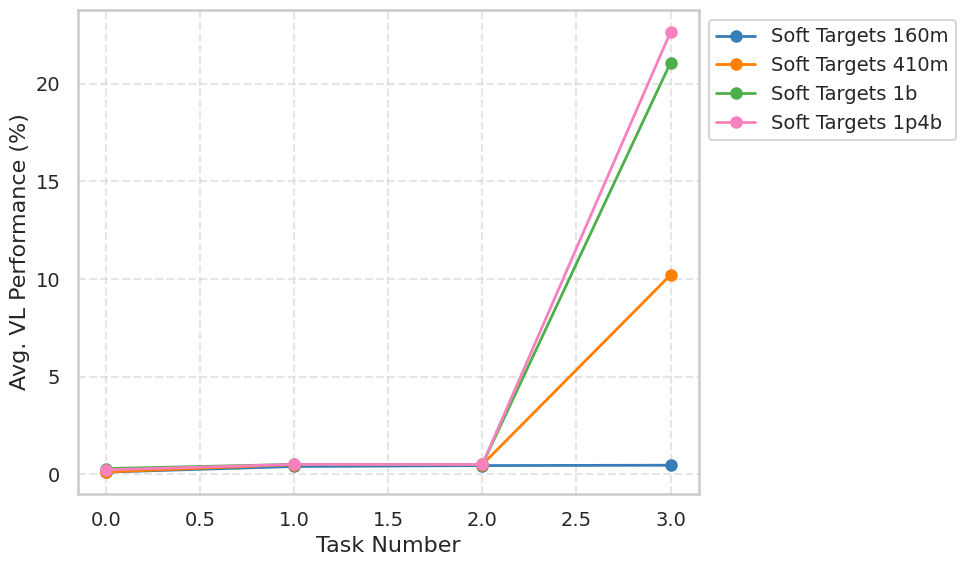

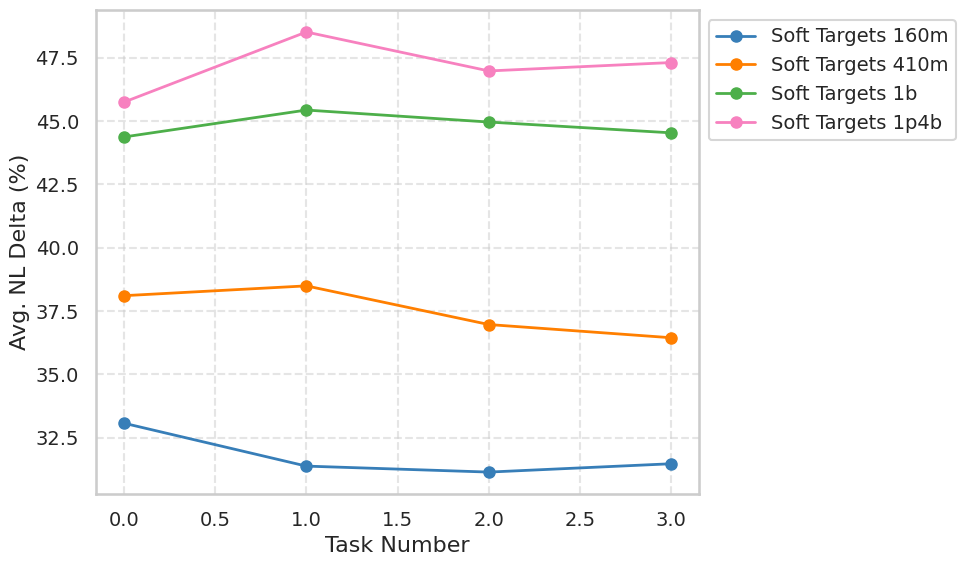

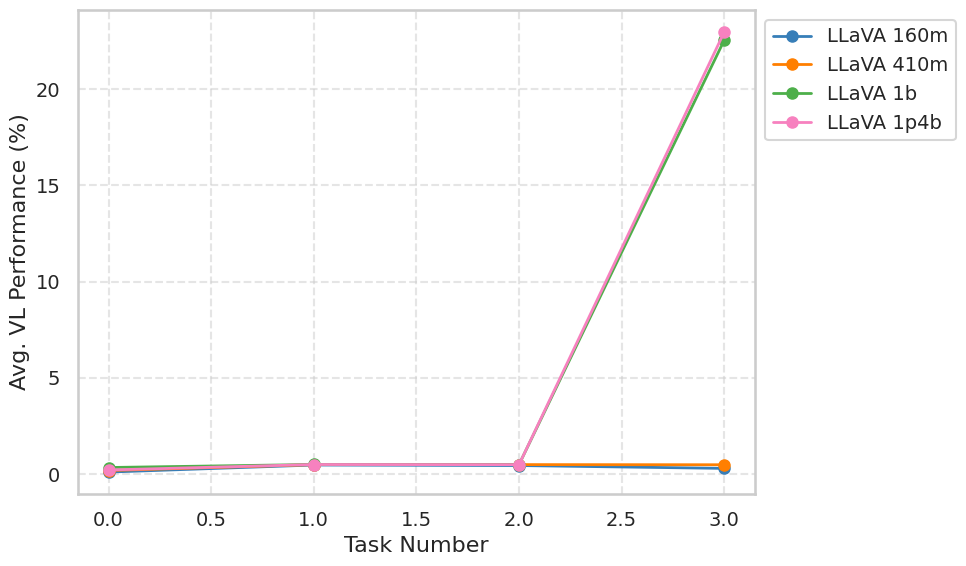

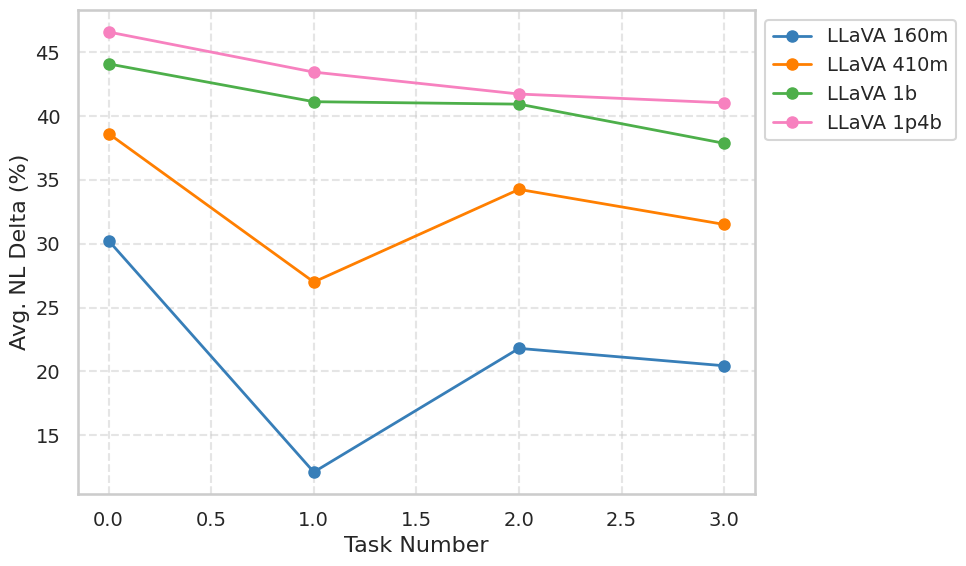

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "410m": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal1", "cl-ref-stage-3-pythia+160m-sgm-rehearsal1"],
    "410m": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1", "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    "160m": "reproduction-align-pythia+160m",
    "410m": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1p4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance_change = {}
    performance = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
            changes[f'stage_{i}'] = change
            performances[f'stage_{i}'] = current_results

            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_datasets])
            avg_delta_vl = hmean(vl_scores) - hmean(baseline_vl_scores)
            avg_acc_vl = hmean(vl_scores)

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_delta_nl = hmean(nl_scores) - hmean(baseline_nl_scores)
            avg_acc_nl = hmean(nl_scores)

            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}

        performance_change[scale] = changes
        performance[scale] = performances

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get performance for plotting
def get_performance_for_plot(performance, model_scales, mapping):
    vl_performance = []
    nl_delta = []
    for scale in model_scales:
        model_key = mapping[scale][0]  # Use the first stage for the key
        vl_performance.append([performance[scale][f'stage_{i}_avg']['VL'] * 100 for i in range(4)])
        nl_delta.append([performance[scale][f'stage_{i}_avg']['NL'] * 100 for i in range(4)])
    return vl_performance, nl_delta

model_scales = ["160m", "410m", "1b", "1p4b"]

our_vl_performance, our_nl_delta = get_performance_for_plot(our_performance, model_scales, our_mapping)
llava_vl_performance, llava_nl_delta = get_performance_for_plot(llava_performance, model_scales, llava_mapping)

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [10, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A',
              '#F781BF', '#A65628', '#984EA3',
              '#999999', '#E41A1C', '#DEDE00']

# Plot Avg. VL Acc for Our Method
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_vl_performance[i], label=f'Soft Targets {scale}', marker='o', linestyle='-', color=CB_palette[i])
plt.xlabel('Task Number')
plt.ylabel('Avg. VL Performance (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('vl_performance_soft_targets.png', dpi=300)

# Plot Avg. NL Delta for Our Method
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_nl_delta[i], label=f'Soft Targets {scale}', marker='o', linestyle='-', color=CB_palette[i])
plt.xlabel('Task Number')
plt.ylabel('Avg. NL Delta (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('nl_delta_soft_targets.png', dpi=300)

# Plot Avg. VL Acc for LLaVA Method
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), llava_vl_performance[i], label=f'LLaVA {scale}', marker='o', linestyle='-', color=CB_palette[i])
plt.xlabel('Task Number')
plt.ylabel('Avg. VL Performance (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('vl_performance_llava.png', dpi=300)

# Plot Avg. NL Delta for LLaVA Method
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), llava_nl_delta[i], label=f'LLaVA {scale}', marker='o', linestyle='-', color=CB_palette[i])
plt.xlabel('Task Number')
plt.ylabel('Avg. NL Delta (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('nl_delta_llava.png', dpi=300)

plt.show()


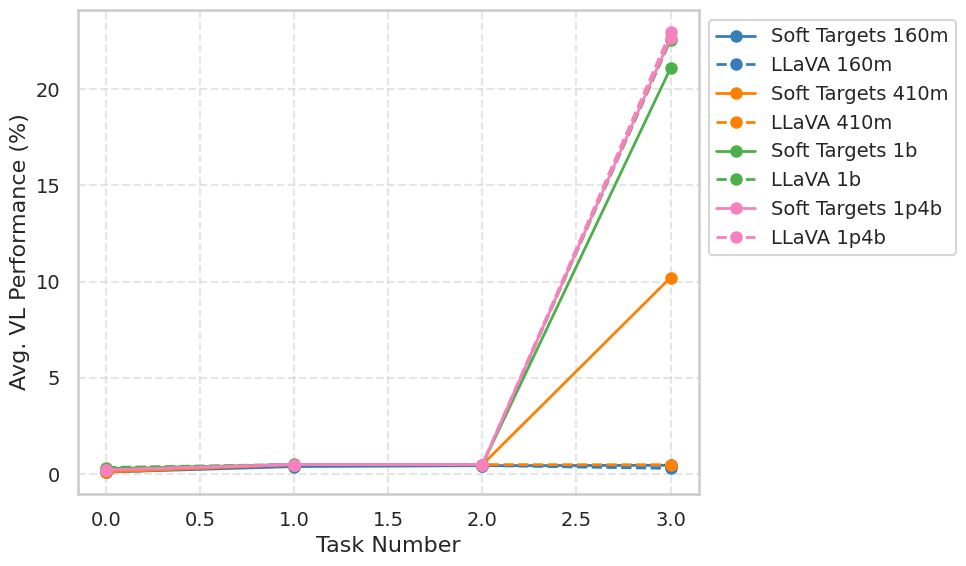

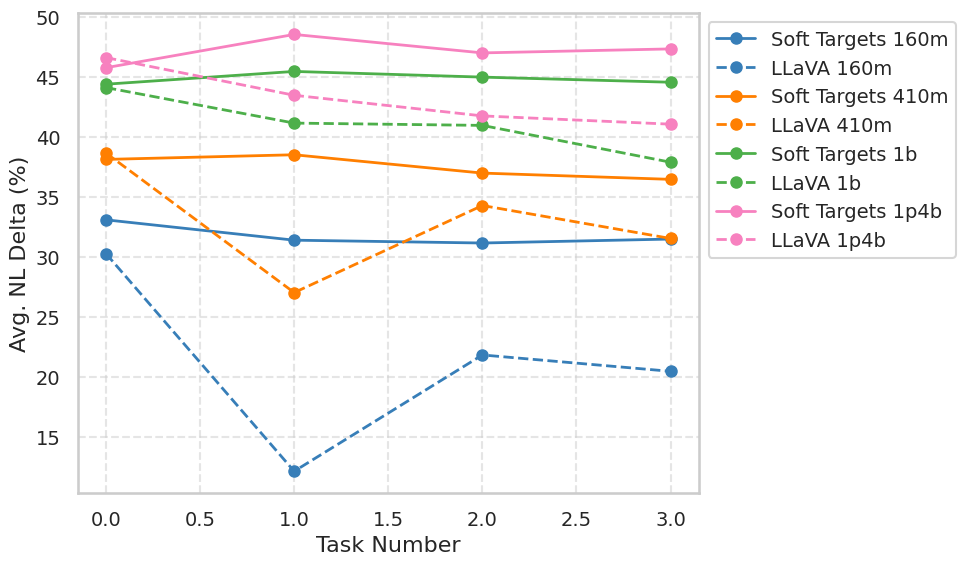

In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Instruct (0)", "VQA (1)", "OCR (2)", "Ref (3)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "410m": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal1", "cl-ref-stage-3-pythia+160m-sgm-rehearsal1"],
    "410m": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1", "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    "160m": "reproduction-align-pythia+160m",
    "410m": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1p4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance_change = {}
    performance = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            change = {dataset: current_results.get(dataset, np.nan) - baseline_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
            changes[f'stage_{i}'] = change
            performances[f'stage_{i}'] = current_results

            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_datasets])
            avg_delta_vl = hmean(vl_scores) - hmean(baseline_vl_scores)
            avg_acc_vl = hmean(vl_scores)

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_delta_nl = hmean(nl_scores) - hmean(baseline_nl_scores)
            avg_acc_nl = hmean(nl_scores)

            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}

        performance_change[scale] = changes
        performance[scale] = performances

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get performance for plotting
def get_performance_for_plot(performance, model_scales, mapping):
    vl_performance = []
    nl_delta = []
    for scale in model_scales:
        model_key = mapping[scale][0]  # Use the first stage for the key
        vl_performance.append([performance[scale][f'stage_{i}_avg']['VL'] * 100 for i in range(4)])
        nl_delta.append([performance[scale][f'stage_{i}_avg']['NL'] * 100 for i in range(4)])
    return vl_performance, nl_delta

model_scales = ["160m", "410m", "1b", "1p4b"]

our_vl_performance, our_nl_delta = get_performance_for_plot(our_performance, model_scales, our_mapping)
llava_vl_performance, llava_nl_delta = get_performance_for_plot(llava_performance, model_scales, llava_mapping)

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [10, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A',
              '#F781BF', '#A65628', '#984EA3',
              '#999999', '#E41A1C', '#DEDE00']

# Plot Avg. VL Acc for Soft Targets and LLaVA
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_vl_performance[i], label=f'Soft Targets {scale}', marker='o', linestyle='-', color=CB_palette[i])
    plt.plot(range(4), llava_vl_performance[i], label=f'LLaVA {scale}', marker='o', linestyle='--', color=CB_palette[i])
plt.xlabel('Task Number')
plt.ylabel('Avg. VL Performance (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('vl_performance_combined.png', dpi=300)

# Plot Avg. NL Delta for Soft Targets and LLaVA
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_nl_delta[i], label=f'Soft Targets {scale}', marker='o', linestyle='-', color=CB_palette[i])
    plt.plot(range(4), llava_nl_delta[i], label=f'LLaVA {scale}', marker='o', linestyle='--', color=CB_palette[i])
plt.xlabel('Task Number')
plt.ylabel('Avg. NL Delta (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('nl_delta_combined.png', dpi=300)

plt.show()


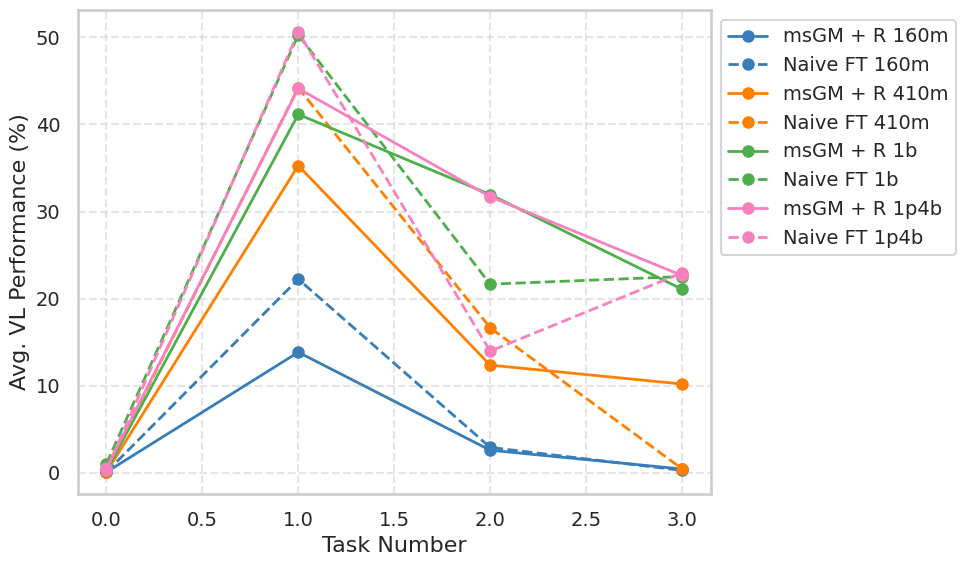

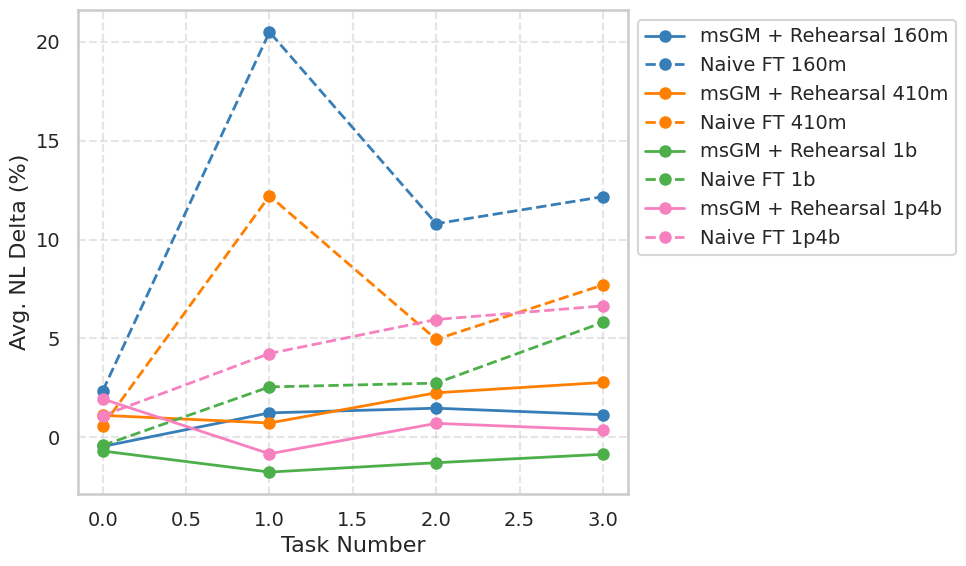

In [11]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Instruct (2)", "VQA (3)", "OCR (4)", "Ref (5)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "410m": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal1", "cl-ref-stage-3-pythia+160m-sgm-rehearsal1"],
    "410m": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1", "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    "160m": "reproduction-align-pythia+160m",
    "410m": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1p4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance_change = {}
    performance = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            change = {dataset: baseline_results.get(dataset, np.nan) - current_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
            changes[f'stage_{i}'] = change
            performances[f'stage_{i}'] = current_results

            vl_evaluate_datasets = vl_evaluate_sequence[i]
            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            avg_delta_vl = hmean(baseline_vl_scores) - hmean(vl_scores)
            avg_acc_vl = hmean(vl_scores)

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_delta_nl = hmean(baseline_nl_scores) - hmean(nl_scores)
            avg_acc_nl = hmean(nl_scores)

            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}

        performance_change[scale] = changes
        performance[scale] = performances

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get performance for plotting
def get_performance_for_plot(performance, change, model_scales, mapping):
    vl_performance = []
    nl_delta = []
    for scale in model_scales:
        vl_performance.append([performance[scale][f'stage_{i}_avg']['VL'] * 100 for i in range(4)])
        nl_delta.append([change[scale][f'stage_{i}_avg']['NL'] * 100 for i in range(4)])
    return vl_performance, nl_delta

model_scales = ["160m", "410m", "1b", "1p4b"]

our_vl_performance, our_nl_delta = get_performance_for_plot(our_performance, our_performance_change, model_scales, our_mapping)
llava_vl_performance, llava_nl_delta = get_performance_for_plot(llava_performance, llava_performance_change, model_scales, llava_mapping)

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [10, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A',
              '#F781BF', '#A65628', '#984EA3',
              '#999999', '#E41A1C', '#DEDE00']

# Plot Avg. VL Acc for Soft Targets and LLaVA
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_vl_performance[i], label=f'msGM + R {scale}', marker='o', linestyle='-', color=CB_palette[i])
    plt.plot(range(4), llava_vl_performance[i], label=f'Naive FT {scale}', marker='o', linestyle='--', color=CB_palette[i])
plt.xlabel('Task Number')
plt.ylabel('Avg. VL Performance (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('vl_performance_combined.png', dpi=300)

# Plot Avg. NL Delta for Soft Targets and LLaVA
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_nl_delta[i], label=f'msGM + Rehearsal {scale}', marker='o', linestyle='-', color=CB_palette[i])
    plt.plot(range(4), llava_nl_delta[i], label=f'Naive FT {scale}', marker='o', linestyle='--', color=CB_palette[i])
plt.xlabel('Task Number')
plt.ylabel('Avg. NL Delta (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('nl_delta_combined.png', dpi=300)

plt.show()


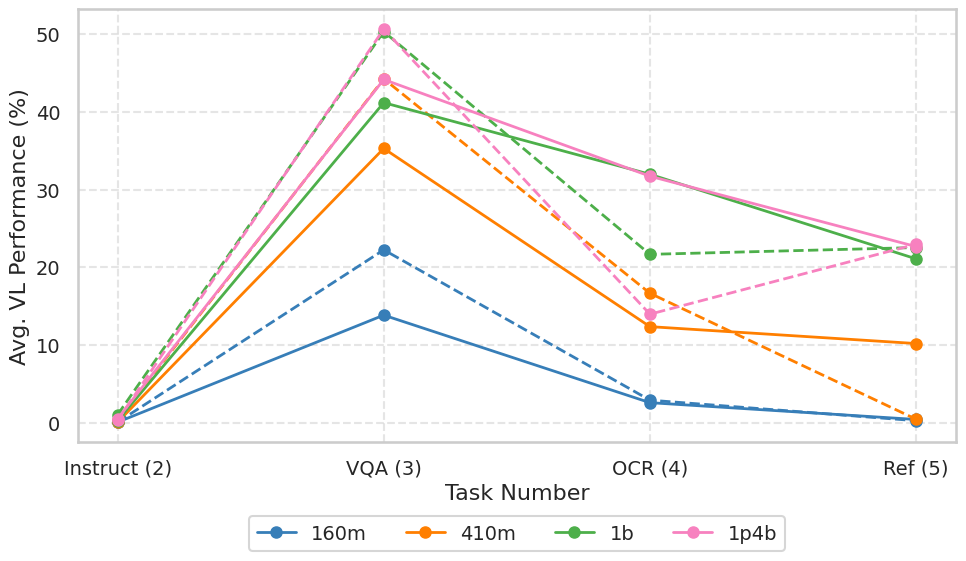

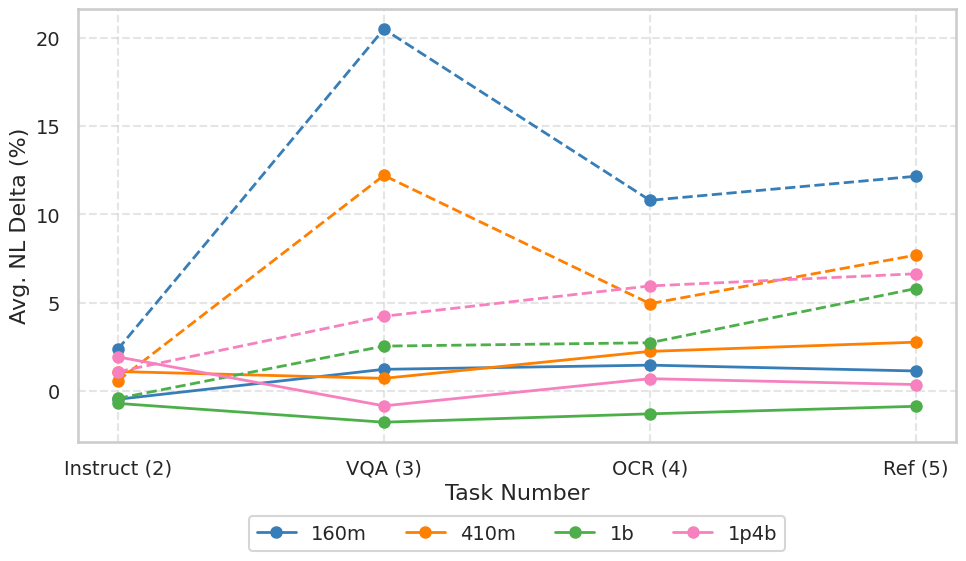

In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Instruct (2)", "VQA (3)", "OCR (4)", "Ref (5)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "410m": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal1", "cl-ref-stage-3-pythia+160m-sgm-rehearsal1"],
    "410m": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1", "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    "160m": "reproduction-align-pythia+160m",
    "410m": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1p4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance_change = {}
    performance = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            change = {dataset: baseline_results.get(dataset, np.nan) - current_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
            changes[f'stage_{i}'] = change
            performances[f'stage_{i}'] = current_results

            vl_evaluate_datasets = vl_evaluate_sequence[i]
            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            avg_delta_vl = hmean(baseline_vl_scores) - hmean(vl_scores)
            avg_acc_vl = hmean(vl_scores)

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_delta_nl = hmean(baseline_nl_scores) - hmean(nl_scores)
            avg_acc_nl = hmean(nl_scores)

            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}

        performance_change[scale] = changes
        performance[scale] = performances

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get performance for plotting
def get_performance_for_plot(performance, change, model_scales, mapping):
    vl_performance = []
    nl_delta = []
    for scale in model_scales:
        vl_performance.append([performance[scale][f'stage_{i}_avg']['VL'] * 100 for i in range(4)])
        nl_delta.append([change[scale][f'stage_{i}_avg']['NL'] * 100 for i in range(4)])
    return vl_performance, nl_delta

model_scales = ["160m", "410m", "1b", "1p4b"]

our_vl_performance, our_nl_delta = get_performance_for_plot(our_performance, our_performance_change, model_scales, our_mapping)
llava_vl_performance, llava_nl_delta = get_performance_for_plot(llava_performance, llava_performance_change, model_scales, llava_mapping)

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [10, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']

# Plot Avg. VL Acc for Soft Targets and LLaVA
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_vl_performance[i], label=f'{scale}', marker='o', linestyle='-', color=CB_palette[i])
    plt.plot(range(4), llava_vl_performance[i], marker='o', linestyle='--', color=CB_palette[i])
plt.xlabel('Task Number')
plt.ylabel('Avg. VL Performance (%)')
plt.xticks(range(4), stages)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.tight_layout()
plt.savefig('vl_performance_combined.png', dpi=300)

# Plot Avg. NL Delta for Soft Targets and LLaVA
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_nl_delta[i], label=f'{scale}', marker='o', linestyle='-', color=CB_palette[i])
    plt.plot(range(4), llava_nl_delta[i], marker='o', linestyle='--', color=CB_palette[i])
plt.xlabel('Task Number')
plt.ylabel('Avg. NL Delta (%)')
plt.xticks(range(4), stages)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.tight_layout()
plt.savefig('nl_delta_combined.png', dpi=300)

plt.show()


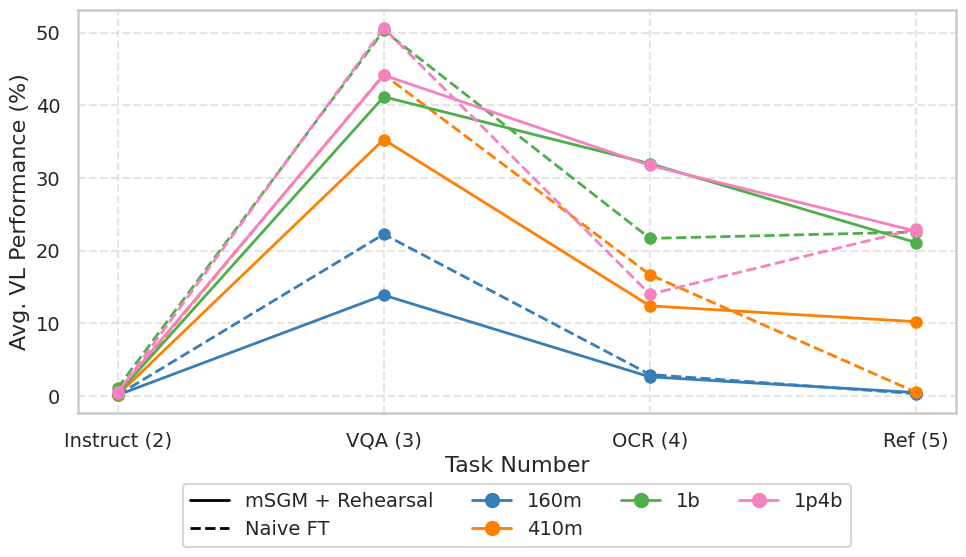

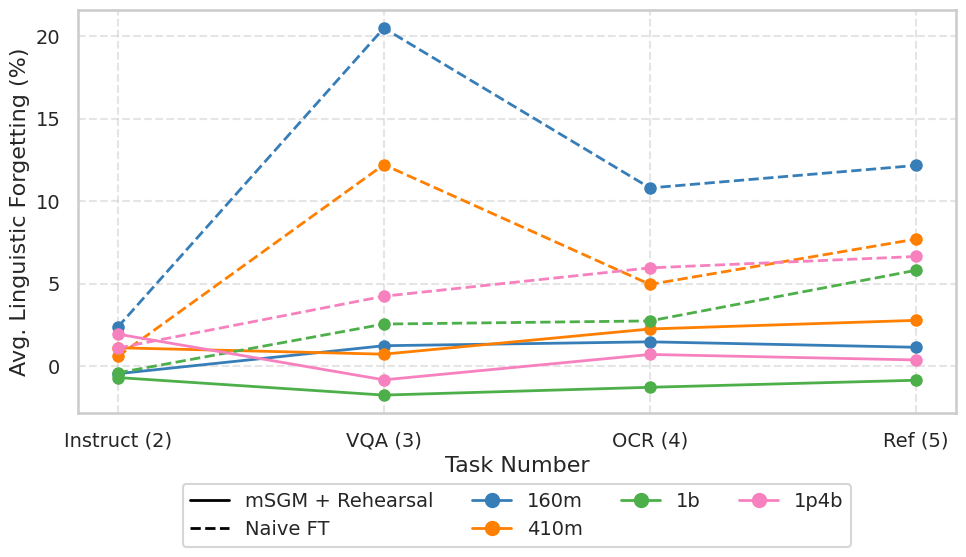

In [15]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Instruct (2)", "VQA (3)", "OCR (4)", "Ref (5)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "410m": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal1", "cl-ref-stage-3-pythia+160m-sgm-rehearsal1"],
    "410m": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1", "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    "160m": "reproduction-align-pythia+160m",
    "410m": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1p4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance_change = {}
    performance = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            change = {dataset: baseline_results.get(dataset, np.nan) - current_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
            changes[f'stage_{i}'] = change
            performances[f'stage_{i}'] = current_results

            vl_evaluate_datasets = vl_evaluate_sequence[i]
            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            avg_delta_vl = hmean(baseline_vl_scores) - hmean(vl_scores)
            avg_acc_vl = hmean(vl_scores)

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_delta_nl = hmean(baseline_nl_scores) - hmean(nl_scores)
            avg_acc_nl = hmean(nl_scores)

            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}

        performance_change[scale] = changes
        performance[scale] = performances

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get performance for plotting
def get_performance_for_plot(performance, change, model_scales, mapping):
    vl_performance = []
    nl_delta = []
    for scale in model_scales:
        vl_performance.append([performance[scale][f'stage_{i}_avg']['VL'] * 100 for i in range(4)])
        nl_delta.append([change[scale][f'stage_{i}_avg']['NL'] * 100 for i in range(4)])
    return vl_performance, nl_delta

model_scales = ["160m", "410m", "1b", "1p4b"]

our_vl_performance, our_nl_delta = get_performance_for_plot(our_performance, our_performance_change, model_scales, our_mapping)
llava_vl_performance, llava_nl_delta = get_performance_for_plot(llava_performance, llava_performance_change, model_scales, llava_mapping)

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [10, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']

# Plot Avg. VL Acc for Soft Targets and LLaVA
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_vl_performance[i], label=f'{scale}', marker='o', linestyle='-', color=CB_palette[i])
    plt.plot(range(4), llava_vl_performance[i], marker='o', linestyle='--', color=CB_palette[i])
plt.xlabel('Task Number')
plt.ylabel('Avg. VL Performance (%)')
plt.xticks(range(4), stages)

# Custom legend handles
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='mSGM + Rehearsal'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Naive FT')
]

plt.legend(handles=custom_lines + [plt.Line2D([], [], color=CB_palette[i], marker='o', linestyle='-', markersize=10, label=f'{scale}') for i, scale in enumerate(model_scales)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.tight_layout()
plt.savefig('vl_performance_combined_cl.png', dpi=300)

# Plot Avg. NL Delta for Soft Targets and LLaVA
plt.figure()
# map scales to appropriate display labels
scale_to_label = {"160m": "160M", "410m": "410M", "1b": "1B", "1p4b": "1.4B"}

for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_nl_delta[i], label=f'{scale_to_label[scale]}', marker='o', linestyle='-', color=CB_palette[i])
    plt.plot(range(4), llava_nl_delta[i], marker='o', linestyle='--', color=CB_palette[i])
plt.xlabel('Task Number')
plt.ylabel('Avg. Linguistic Forgetting (%)')
plt.xticks(range(4), stages)

# Custom legend handles
custom_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='mSGM + Rehearsal'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Naive FT')
]

plt.legend(handles=custom_lines + [plt.Line2D([], [], color=CB_palette[i], marker='o', linestyle='-', markersize=10, label=f'{scale}') for i, scale in enumerate(model_scales)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.tight_layout()
plt.savefig('nl_delta_combined_cl.png', dpi=300)

plt.show()


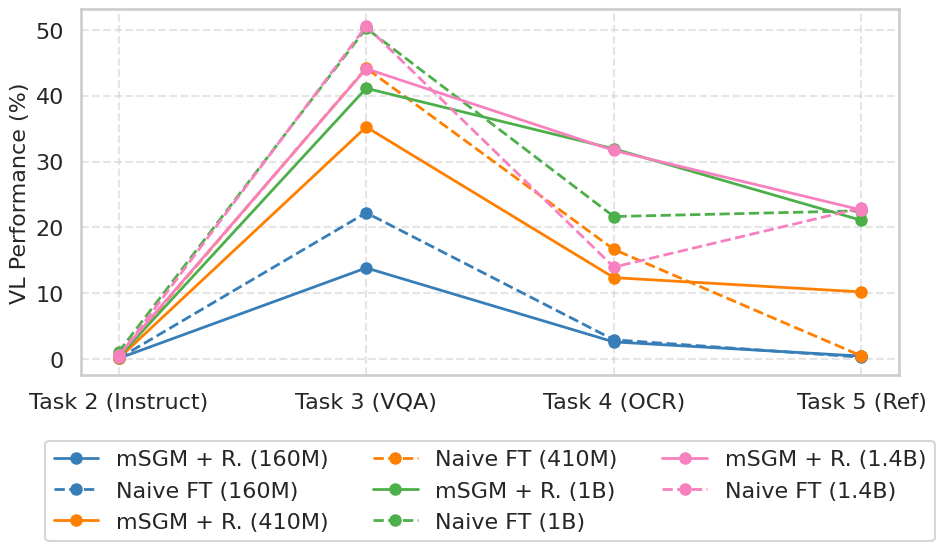

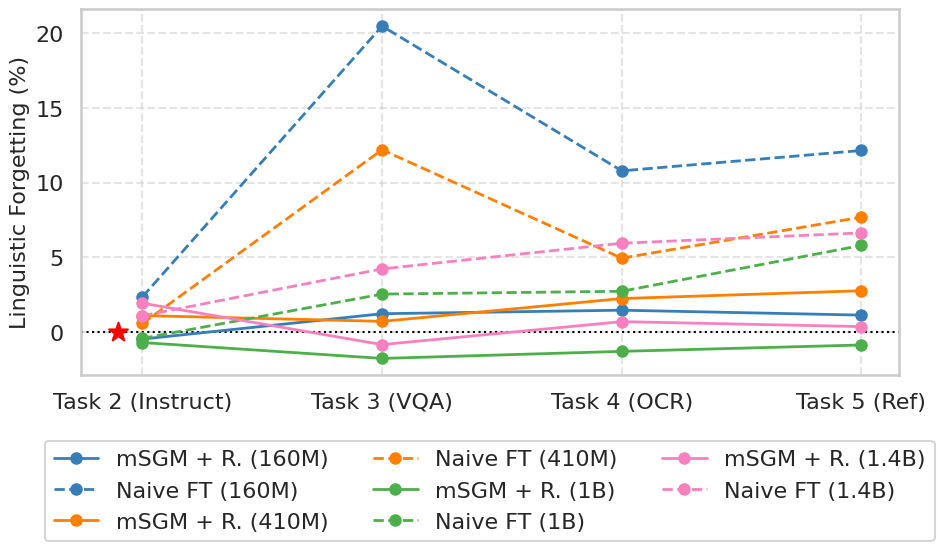

In [69]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Task 2 (Instruct)", "Task 3 (VQA)", "Task 4 (OCR)", "Task 5 (Ref)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "410m": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal1", "cl-ref-stage-3-pythia+160m-sgm-rehearsal1"],
    "410m": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1", "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    "160m": "reproduction-align-pythia+160m",
    "410m": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1p4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance_change = {}
    performance = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            change = {dataset: baseline_results.get(dataset, np.nan) - current_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
            changes[f'stage_{i}'] = change
            performances[f'stage_{i}'] = current_results

            vl_evaluate_datasets = vl_evaluate_sequence[i]
            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            avg_delta_vl = hmean(baseline_vl_scores) - hmean(vl_scores)
            avg_acc_vl = hmean(vl_scores)

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_delta_nl = hmean(baseline_nl_scores) - hmean(nl_scores)
            avg_acc_nl = hmean(nl_scores)

            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}

        performance_change[scale] = changes
        performance[scale] = performances

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get performance for plotting
def get_performance_for_plot(performance, change, model_scales, mapping):
    vl_performance = []
    nl_delta = []
    for scale in model_scales:
        vl_performance.append([performance[scale][f'stage_{i}_avg']['VL'] * 100 for i in range(4)])
        nl_delta.append([change[scale][f'stage_{i}_avg']['NL'] * 100 for i in range(4)])
    return vl_performance, nl_delta

model_scales = ["160m", "410m", "1b", "1p4b"]

our_vl_performance, our_nl_delta = get_performance_for_plot(our_performance, our_performance_change, model_scales, our_mapping)
llava_vl_performance, llava_nl_delta = get_performance_for_plot(llava_performance, llava_performance_change, model_scales, llava_mapping)

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.figsize': [10, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']
# Plot Avg. NL Delta for Soft Targets and LLaVA
scale_to_label = {"160m": "160M", "410m": "410M", "1b": "1B", "1p4b": "1.4B"}
# Plot Avg. VL Acc for Soft Targets and LLaVA
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_vl_performance[i], label=f'mSGM + R. ({scale_to_label[scale]})', marker='o', linestyle='-', color=CB_palette[i])
    plt.plot(range(4), llava_vl_performance[i], label=f'Naive FT ({scale_to_label[scale]})', marker='o', linestyle='--', color=CB_palette[i])
# plt.xlabel('Task Number')
plt.ylabel('VL Performance (%)')
plt.xticks(range(4), stages)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.savefig('vl_performance_combined_cl.png', dpi=300)

plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_nl_delta[i], label=f'mSGM + R. ({scale_to_label[scale]})', marker='o', linestyle='-', color=CB_palette[i])
    plt.plot(range(4), llava_nl_delta[i], label=f'Naive FT ({scale_to_label[scale]})', marker='o', linestyle='--', color=CB_palette[i])
# plt.xlabel('Task Number')
plt.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=1)
plt.scatter(-0.1, 0, color='red', marker='*', s=200, zorder=5) 

plt.ylabel('Linguistic Forgetting (%)')
plt.xticks(range(4), stages)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.savefig('nl_delta_combined_cl.png', dpi=300)

plt.show()


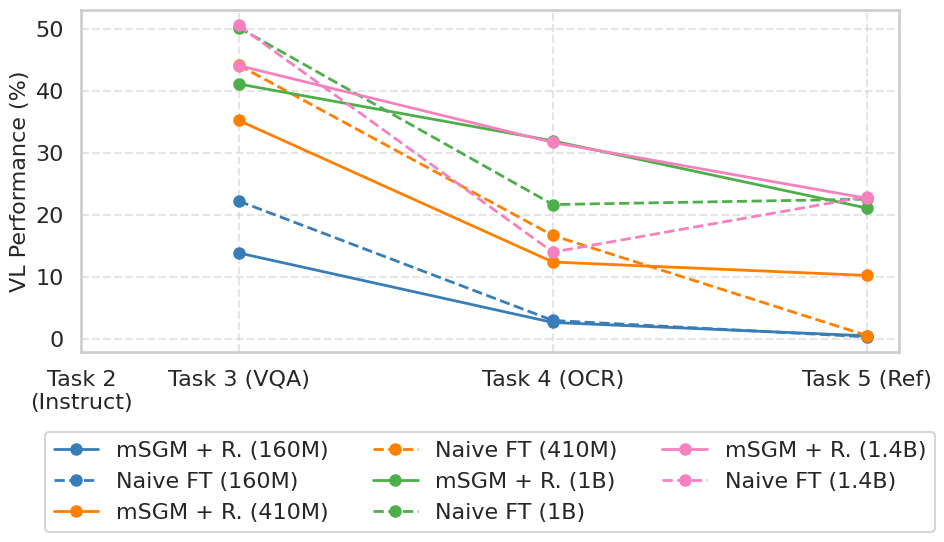

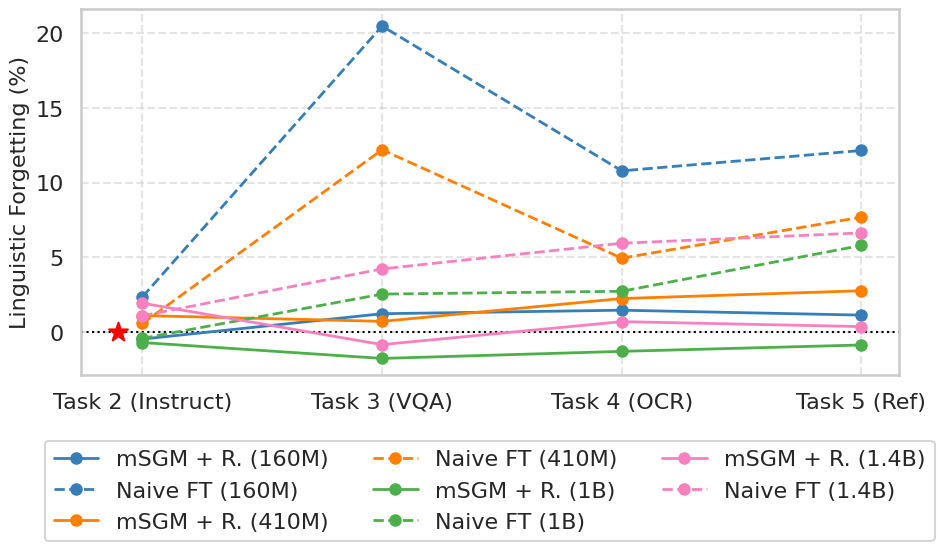

In [28]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Task 2 (Instruct)", "Task 3 (VQA)", "Task 4 (OCR)", "Task 5 (Ref)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "410m": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "160m": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal1", "cl-ref-stage-3-pythia+160m-sgm-rehearsal1"],
    "410m": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1", "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    "1p4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    "160m": "reproduction-align-pythia+160m",
    "410m": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1p4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance_change = {}
    performance = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            change = {dataset: baseline_results.get(dataset, np.nan) - current_results.get(dataset, np.nan) for dataset in baseline_results.keys()}
            changes[f'stage_{i}'] = change
            performances[f'stage_{i}'] = current_results

            vl_evaluate_datasets = vl_evaluate_sequence[i]
            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            avg_delta_vl = hmean(baseline_vl_scores) - hmean(vl_scores)
            avg_acc_vl = hmean(vl_scores)

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_delta_nl = hmean(baseline_nl_scores) - hmean(nl_scores)
            avg_acc_nl = hmean(nl_scores)

            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}
            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}

        performance_change[scale] = changes
        performance[scale] = performances

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get performance for plotting
def get_performance_for_plot(performance, change, model_scales, mapping):
    vl_performance = []
    nl_delta = []
    for scale in model_scales:
        vl_performance.append([performance[scale][f'stage_{i}_avg']['VL'] * 100 for i in range(4)])
        nl_delta.append([change[scale][f'stage_{i}_avg']['NL'] * 100 for i in range(4)])
    return vl_performance, nl_delta

model_scales = ["160m", "410m", "1b", "1p4b"]

our_vl_performance, our_nl_delta = get_performance_for_plot(our_performance, our_performance_change, model_scales, our_mapping)
llava_vl_performance, llava_nl_delta = get_performance_for_plot(llava_performance, llava_performance_change, model_scales, llava_mapping)

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.figsize': [10, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']
# Plot Avg. NL Delta for Soft Targets and LLaVA
scale_to_label = {"160m": "160M", "410m": "410M", "1b": "1B", "1p4b": "1.4B"}

# Plot Avg. VL Acc for Soft Targets and LLaVA
plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(1, 4), our_vl_performance[i][1:], label=f'mSGM + R. ({scale_to_label[scale]})', marker='o', linestyle='-', color=CB_palette[i])
    plt.plot(range(1, 4), llava_vl_performance[i][1:], label=f'Naive FT ({scale_to_label[scale]})', marker='o', linestyle='--', color=CB_palette[i])
plt.ylabel('VL Performance (%)')
plt.xticks([0.50, 1, 2, 3], ["Task 2\n(Instruct)", "Task 3 (VQA)", "Task 4 (OCR)", "Task 5 (Ref)"])
plt.xlim(0.5, 3.1)  # Adjusting xlim to reduce the space between Task 2 and Task 3

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.tight_layout()
plt.savefig('vl_performance_combined_cl.png', dpi=300)

plt.figure()
for i, scale in enumerate(model_scales):
    plt.plot(range(4), our_nl_delta[i], label=f'mSGM + R. ({scale_to_label[scale]})', marker='o', linestyle='-', color=CB_palette[i])
    plt.plot(range(4), llava_nl_delta[i], label=f'Naive FT ({scale_to_label[scale]})', marker='o', linestyle='--', color=CB_palette[i])
plt.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=1)
plt.scatter(-0.1, 0, color='red', marker='*', s=200, zorder=5) 

plt.ylabel('Linguistic Forgetting (%)')
plt.xticks(range(4), stages)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.savefig('nl_delta_combined_cl.png', dpi=300)

plt.show()
